# This notebook computes the stacks of single pair examples
Tasks include:
* Stacking of single pairs for Cascadia amphibious and the XZ examples
* Compute convergence rate for all examples
* Compute CPU time for stacking while computing the convergence rate.

In [1]:
import os,random,time,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.signal.filter import bandpass
from seisgo import noise,utils,plotting
from seisgo.stacking import seisstack as stack

## Global parameters

In [2]:
dataroot='data_stacking'
comp="ZZ"
raw=os.path.join(dataroot,"MERGED_cascadia_raw")
tnorm=os.path.join(dataroot,"MERGED_cascadia_tnorm")
raw_xz=os.path.join(dataroot,"MERGED_XZ_raw")
tnorm_xz=os.path.join(dataroot,"MERGED_XZ_tnorm")

#
figformat="png"
figdpi=200

dlabels=["Raw","One-bit"]
cmap="seismic"
methods=["linear","robust","selective","cluster","pws","tfpws-dost","nroot","acf"]
method_labels=["Linear","Robust","Selective","Cluster","PWS","tf-PWS","$N^{th}$-root","ACF"]
colors=["k","b","c","y","g","orange","r","m"]

figlabels=["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)"]

## Single pair examples: Cascadia single pair

In [3]:
source="7D.J33A"
receiver="TA.G03D"
network="cascadia"
pair=source+"_"+receiver
raw=os.path.join(dataroot,"MERGED_cascadia_raw")
datadir_raw=os.path.join(raw,source)
dfile_raw=datadir_raw+"/"+pair+".h5"
cdata_raw=noise.extract_corrdata(dfile_raw,pair=pair,comp=comp)[pair][comp]
tnorm=os.path.join(dataroot,"MERGED_cascadia_tnorm")
datadir_tnorm=os.path.join(tnorm,source)
dfile_tnorm=datadir_tnorm+"/"+pair+".h5"
cdata_tnorm=noise.extract_corrdata(dfile_tnorm,pair=pair,comp=comp)[pair][comp]

### Now we will plot the two cc results side by side, for visualization before stacking

In [11]:
savefig=True

cdata_all=[cdata_raw,cdata_tnorm]
lag=300
freqmin,freqmax=[0.04,0.4]
figsize=(13,5.5)
cmap="seismic"
plt.figure(figsize=figsize,facecolor='w')
snr_all=[]
for i,c in enumerate(cdata_all):
    netstachan1 = c.net[0]+'.'+c.sta[0]#+'.'+c.loc[0]+'.'+c.chan[0]
    netstachan2 = c.net[1]+'.'+c.sta[1]#+'.'+c.loc[1]+'.'+c.chan[1]

    dt,maxlag,dist,ttime,substack = [c.dt,c.lag,c.dist,\
                                            c.time,c.substack]
    
   # lags for display
    if not lag:lag=maxlag
    if lag>maxlag:raise ValueError('lag excceds maxlag!')
    lag0=np.min([1.0*lag,maxlag])
    tvec=np.arange(-lag0,lag0+0.5*dt,dt)
    
    # t is the time labels for plotting
    if lag>=5:
        tstep=int(int(lag)/5)
        t1=np.arange(-int(lag),0,step=tstep);t2=np.arange(0,int(lag+0.5*tstep),step=tstep)
        t=np.concatenate((t1,t2))
    else:
        tstep=lag/5
        t1=np.arange(-lag,0,step=tstep);t2=np.arange(0,lag+0.5*tstep,step=tstep)
        t=np.concatenate((t1,t2))

    indx1 = int((maxlag-lag0)/dt);indx2 = indx1+2*int(lag0/dt)+1

    # cc matrix
    data = np.ndarray.copy(c.data[:,indx1:indx2])
    timestamp = np.empty(ttime.size,dtype='datetime64[s]')
    # print(data.shape)
    nwin = data.shape[0]
    amax = np.zeros(nwin,dtype=np.float32)
    if nwin==0:
        print('continue! no enough trace to plot!')

    tmarks = []
    data_normalizd=np.zeros(data.shape)

    # load cc for each station-pair
    for ii in range(nwin):
        if freqmin is not None and freqmax is not None:
            data[ii] = bandpass(data[ii],freqmin,freqmax,1/dt,corners=4, zerophase=True)
        data[ii] = utils.taper(data[ii]-np.mean(data[ii]),maxlen=10)
        amax[ii] = np.max(np.abs(data[ii]))
        data_normalizd[ii] = data[ii]/amax[ii]
        timestamp[ii] = UTCDateTime(ttime[ii])
        tmarks.append(UTCDateTime(ttime[ii]).strftime('%Y-%m-%dT%H'))

    # plotting
    if nwin>10:
        tick_inc = int(nwin/6)
    else:
        tick_inc = 2

#     plt.subplot(1,6*len(cdata_all),(i*6+1,i*6+4))
    plt.subplot(1,len(cdata_all),i+1)
    extent=[-lag0,lag0,nwin,0]

    plt.imshow(data_normalizd,cmap=cmap,extent=extent,aspect='auto')
    
    tstack=np.arange(-lag0,lag0+0.5*dt,dt)
    dstack = np.mean(data,axis=0)
    dstack /= np.max(np.abs(dstack))
    if len(tstack)>len(dstack):tstack=tstack[:-2]
    plt.plot(tstack,-35+30*dstack,'b-',linewidth=1,label="linear stack")
    plt.text(-0.9*lag,-50,"average",color='b')
    # zero line
    plt.plot((0,0),(nwin,-70),'k-')
    plt.ylim([nwin,-70])
    if freqmin is not None and freqmax is not None:
        plt.title('%s %s-%s: %d km: %s' % (figlabels[i],netstachan1,netstachan2,
                                                                   dist,dlabels[i]),
                    fontsize=14,loc="left",pad=9)
        plt.text(0.35*lag,nwin*0.95,"%4.2f-%4.2f Hz"%(freqmin,freqmax),backgroundcolor="w",
                fontsize=13)
    else:
        plt.title('%s %s-%s: %d km: %s' % (figlabels[i],netstachan1,netstachan2,dist,dlabels[i]),
                 fontsize=14,loc="left",pad=9)
        plt.text(0.35*lag,nwin*0.95,"unfiltered",backgroundcolor="w",fontsize=14)
    plt.xlabel('lag time (s)',fontsize=13)
    plt.xticks(t)
    plt.yticks(np.arange(0,nwin,step=tick_inc),labels=tmarks[0:nwin:tick_inc])
    plt.xlim([-lag,lag])
    plt.colorbar(orientation="horizontal",label="normalized amplitudes")

plt.tight_layout()

#
if savefig:
    plt.savefig("xcorr_examples_"+network+"."+figformat,dpi=figdpi)
    plt.close()
else:
    plt.show()

### Construct stacking examples for the above station pair

In [5]:
vmin=2 
vmax=4.5

stack_all={dlabels[0]:[],dlabels[1]:[],"lag":lag,"tvec":None,"dt":None} #store
for i,c in enumerate(cdata_all):
    netstachan1 = c.net[0]+'.'+c.sta[0]#+'.'+c.loc[0]+'.'+c.chan[0]
    netstachan2 = c.net[1]+'.'+c.sta[1]#+'.'+c.loc[1]+'.'+c.chan[1]

    dt,maxlag,dist,ttime,substack = [c.dt,c.lag,c.dist,\
                                            c.time,c.substack]
    tvec=np.arange(-maxlag,maxlag+0.5*dt,dt)
    stack_all["tvec"]=tvec
    stack_all["dt"]=dt

    # cc matrix
    data = c.data.copy()
    # print(data.shape)
    nwin = data.shape[0]
    if nwin==0:
        print('continue! no enough trace to plot!')

    """
    Begin stacking
    """
    stack_all[dlabels[i]]=np.ndarray((len(methods),data.shape[1]))
    for j,m in enumerate(methods):
        ds = stack(data,m)
        stack_all[dlabels[i]][j]=ds

with open('xcorr_stacks_singlepair_stack_all_'+network+'.pk','wb') as xf:
    pickle.dump(stack_all,xf)

## Convergence rate of all stacking methods
Increase from 5 to the whole length, randomly resample a subset of the whole NCFs. All method will use the same randomly sampled data set for stacking. However, each stacking result will compare with the stack of whole dataset using the same method.

The cell below also computes and saves the CPU time while testing the convergence rate.

In [6]:
stack_convergence=dict()
stack_cputime={dlabels[0]:[],dlabels[1]:[]}
step=5
nstart=step
for i,c in enumerate(cdata_all):
    dt = c.dt
    c_temp=c.subset(endtime="2012_04_1_0_0_0",overwrite=False)
    ntrace=c_temp.data.shape[0]
    stepall=np.arange(nstart,ntrace+0.5*step,step)
    stack_convergence[dlabels[i]]=np.ndarray((len(method_labels),len(stepall)))
    stack_cputime[dlabels[i]]=np.ndarray((len(method_labels),len(stepall)))
    stack_convergence["stepall"]=stepall
    stack_cputime["stepall"]=stepall
    stack_temp=np.ndarray((len(method_labels),c.data.shape[1]))
    for j,m in enumerate(methods):
        ds00 = stack(c_temp.data,m)
        ds1=bandpass(ds00,freqmin,freqmax,1/dt,corners=4, zerophase=True)
        stack_temp[j,:]=ds1
                
    for k,s in enumerate(stepall):
        print(int(s))       
        # cc matrix
        data = c_temp.data[:int(s),:].copy()
        # print(data.shape)

        """
        Begin stacking
        """
        for j,m in enumerate(methods):
            t0=time.time()
            ds0 = stack(data,m)
            stack_cputime[dlabels[i]][j,k]=time.time() - t0
            ds=bandpass(ds0,freqmin,freqmax,1/dt,corners=4, zerophase=True)

            stack_convergence[dlabels[i]][j,k]=np.corrcoef(ds,stack_temp[j,:])[0,1]
        #

with open('xcorr_stacks_singlepair_convergence_step%d_%s.pk'%(step,network),'wb') as xf:
    pickle.dump(stack_convergence,xf)
with open('xcorr_stacks_singlepair_cputime_step%d_%s.pk'%(step,network),'wb') as xf:
    pickle.dump(stack_cputime,xf)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300


## Single pair examples: XZ single pair

In [7]:
source="XZ.A02"
receiver="XZ.A24"
network="XZ"
pair=source+"_"+receiver
datadir_raw_xz=os.path.join(raw_xz,source)
dfile_raw_xz=datadir_raw_xz+"/"+pair+".h5"
cdata_raw_xz=noise.extract_corrdata(dfile_raw_xz,pair=pair,comp=comp)[pair][comp]
datadir_tnorm_xz=os.path.join(tnorm_xz,source)
dfile_tnorm_xz=datadir_tnorm_xz+"/"+pair+".h5"
cdata_tnorm_xz=noise.extract_corrdata(dfile_tnorm_xz,pair=pair,comp=comp)[pair][comp]

### XCORR plots

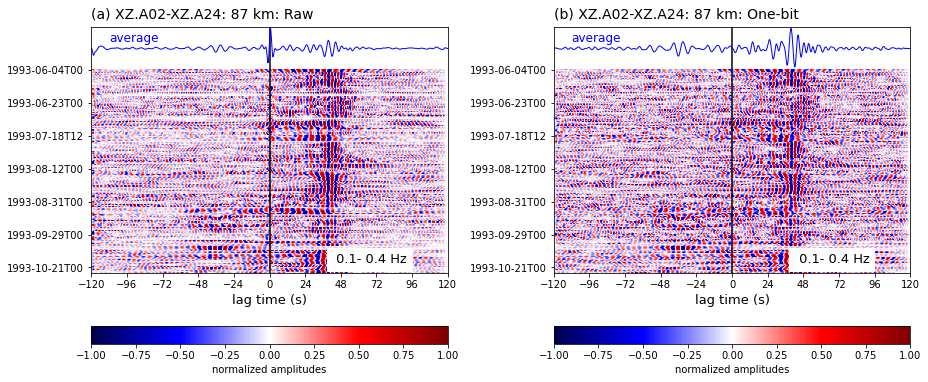

In [8]:
savefig=False
cdata_all=[cdata_raw_xz,cdata_tnorm_xz]
lag=120
freqmin,freqmax=[0.1,.4]
figsize=(13,5.5)
cmap="seismic"
plt.figure(figsize=figsize,facecolor='w')
snr_all=[]
for i,c in enumerate(cdata_all):
    netstachan1 = c.net[0]+'.'+c.sta[0]#+'.'+c.loc[0]+'.'+c.chan[0]
    netstachan2 = c.net[1]+'.'+c.sta[1]#+'.'+c.loc[1]+'.'+c.chan[1]

    dt,maxlag,dist,ttime,substack = [c.dt,c.lag,c.dist,\
                                            c.time,c.substack]
    
   # lags for display
    if not lag:lag=maxlag
    if lag>maxlag:raise ValueError('lag excceds maxlag!')
    lag0=np.min([1.0*lag,maxlag])
    tvec=np.arange(-lag0,lag0+0.5*dt,dt)
    
    # t is the time labels for plotting
    if lag>=5:
        tstep=int(int(lag)/5)
        t1=np.arange(-int(lag),0,step=tstep);t2=np.arange(0,int(lag+0.5*tstep),step=tstep)
        t=np.concatenate((t1,t2))
    else:
        tstep=lag/5
        t1=np.arange(-lag,0,step=tstep);t2=np.arange(0,lag+0.5*tstep,step=tstep)
        t=np.concatenate((t1,t2))

    indx1 = int((maxlag-lag0)/dt);indx2 = indx1+2*int(lag0/dt)+1

    # cc matrix
    data = np.ndarray.copy(c.data[:,indx1:indx2])
    timestamp = np.empty(ttime.size,dtype='datetime64[s]')
    # print(data.shape)
    nwin = data.shape[0]
    amax = np.zeros(nwin,dtype=np.float32)
    if nwin==0:
        print('continue! no enough trace to plot!')

    tmarks = []
    data_normalizd=np.zeros(data.shape)

    # load cc for each station-pair
    for ii in range(nwin):
        if freqmin is not None and freqmax is not None:
            data[ii] = bandpass(data[ii],freqmin,freqmax,1/dt,corners=4, zerophase=True)
        data[ii] = utils.taper(data[ii]-np.mean(data[ii]),maxlen=10)
        amax[ii] = np.max(np.abs(data[ii]))
        data_normalizd[ii] = data[ii]/amax[ii]
        timestamp[ii] = UTCDateTime(ttime[ii])
        tmarks.append(UTCDateTime(ttime[ii]).strftime('%Y-%m-%dT%H'))

    # plotting
    if nwin>10:
        tick_inc = int(nwin/6)
    else:
        tick_inc = 2

#     plt.subplot(1,6*len(cdata_all),(i*6+1,i*6+4))
    plt.subplot(1,len(cdata_all),i+1)
    extent=[-lag0,lag0,nwin,0]

    plt.imshow(data_normalizd,cmap=cmap,extent=extent,aspect='auto')
    
    tstack=np.arange(-lag0,lag0+0.5*dt,dt)
    dstack = np.mean(data,axis=0)
    dstack /= np.max(np.abs(dstack))
    if len(tstack)>len(dstack):tstack=tstack[:-2]
    plt.plot(tstack,-15+14*dstack,'b-',linewidth=1,label="linear stack")
    plt.text(-0.9*lag,-20,"average",color='b',fontsize=12)
    # zero line
    plt.vlines(0,-30,nwin,colors='k')
    plt.ylim([nwin,-30])
    if freqmin is not None and freqmax is not None:
        plt.title('%s %s-%s: %d km: %s' % (figlabels[i],netstachan1,netstachan2,
                                                                   dist,dlabels[i]),
                    fontsize=14,loc="left",pad=9)
        plt.text(0.35*lag,nwin*0.95,"%4.1f-%4.1f Hz"%(freqmin,freqmax),backgroundcolor="w",
                fontsize=13)
    else:
        plt.title('%s %s-%s: %d km: %s' % (figlabels[i],netstachan1,netstachan2,dist,dlabels[i]),
                 fontsize=14,loc="left",pad=9)
        plt.text(0.35*lag,nwin*0.95,"unfiltered",backgroundcolor="w",fontsize=14)
    plt.xlabel('lag time (s)',fontsize=13)
    plt.xticks(t)
    plt.yticks(np.arange(0,nwin,step=tick_inc),labels=tmarks[0:nwin:tick_inc])
    plt.xlim([-lag,lag])
    plt.colorbar(orientation="horizontal",label="normalized amplitudes")

plt.tight_layout()
if savefig:
    plt.savefig("xcorr_examples_"+network+"."+figformat,dpi=figdpi)
    plt.close()
else:
    plt.show()

### compute stacks

In [9]:
cdata_all=[cdata_raw_xz,cdata_tnorm_xz]
stack_all={dlabels[0]:[],dlabels[1]:[],"lag":lag,"tvec":None,"dt":None} #store
for i,c in enumerate(cdata_all):
    netstachan1 = c.net[0]+'.'+c.sta[0]#+'.'+c.loc[0]+'.'+c.chan[0]
    netstachan2 = c.net[1]+'.'+c.sta[1]#+'.'+c.loc[1]+'.'+c.chan[1]

    dt,maxlag,dist,ttime,substack = [c.dt,c.lag,c.dist,\
                                            c.time,c.substack]
    tvec=np.arange(-maxlag,maxlag+0.5*dt,dt)
    stack_all["tvec"]=tvec
    stack_all["dt"]=dt

    # cc matrix
    data = c.data.copy()
    # print(data.shape)
    nwin = data.shape[0]
    if nwin==0:
        print('continue! no enough trace to plot!')

    """
    Begin stacking
    """
    stack_all[dlabels[i]]=np.ndarray((len(methods),data.shape[1]))
    for j,m in enumerate(methods):
        ds = stack(data,m)
        stack_all[dlabels[i]][j]=ds

with open('xcorr_stacks_singlepair_stack_all_'+network+'.pk','wb') as xf:
    pickle.dump(stack_all,xf)

### rate of convergence

In [10]:
stack_convergence=dict()
stack_cputime={dlabels[0]:[],dlabels[1]:[]}
nstart=2
step=2
for i,c in enumerate(cdata_all):
    dt = c.dt
    ntrace=c.data.shape[0]
    stepall=np.arange(nstart,ntrace+0.5*step,step)
    stack_convergence[dlabels[i]]=np.ndarray((len(method_labels),len(stepall)))
    stack_cputime[dlabels[i]]=np.ndarray((len(method_labels),len(stepall)))
    stack_convergence["stepall"]=stepall
    stack_cputime["stepall"]=stepall
    stack_temp=np.ndarray((len(method_labels),c.data.shape[1]))
    for j,m in enumerate(methods):
        ds00 = stack(c.data,m)
        ds1=bandpass(ds00,freqmin,freqmax,1/dt,corners=4, zerophase=True)
        stack_temp[j,:]=ds1
                
    for k,s in enumerate(stepall):
        print(int(s))       
        # cc matrix
        data = np.ndarray.copy(c.data[:int(s),:])
        # print(data.shape)

        """
        Begin stacking
        """
        for j,m in enumerate(methods):
            t0=time.time()
            ds0 = stack(data,m)
            stack_cputime[dlabels[i]][j,k]=time.time() - t0
            ds=bandpass(ds0,freqmin,freqmax,1/dt,corners=4, zerophase=True)

            stack_convergence[dlabels[i]][j,k]=np.corrcoef(ds,stack_temp[j,:])[0,1]
        #

with open('xcorr_stacks_singlepair_convergence_step%d_%s.pk'%(step,network),'wb') as xf:
    pickle.dump(stack_convergence,xf)
with open('xcorr_stacks_singlepair_cputime_step%d_%s.pk'%(step,network),'wb') as xf:
    pickle.dump(stack_cputime,xf)

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
